In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import LambdaCDM as LCDM
import numpy.ma as ma
import healpy as hp
import matplotlib as mpl
import emcee

## My modules
from Clustering_module import *


DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

cosmo = LCDM(H0=71, Om0=0.26, Ode0=0.74, Ob0=0.0435)

schind_23_file_name = DP2_DIRECTORY + "Data/apjaca7cat7_ascii.txt"
schind_23_data = open(schind_23_file_name, 'r')
ra_col_schind_23 = []
dec_col_schind_23 = []
red_col_schind_23 = []
mag_col_schind_23 = []

skip_rows = 6
for line in schind_23_data:
    if (skip_rows > 0):
        skip_rows -= 1
        continue
    split_line = line.split()
    quasar_name = split_line[0] 
    red_col_schind_23.append(float(split_line[2]))
    ra_col_schind_23.append(float(quasar_name[4:13]))
    dec_col_schind_23.append(float(quasar_name[13:21]))

    mag_col_schind_23.append(float(split_line[3]))
    
ra_col_schind_23 = np.array(ra_col_schind_23)
dec_col_schind_23 = np.array(dec_col_schind_23)
red_col_schind_23 = np.array(red_col_schind_23)
mag_col_schind_23 = np.array(mag_col_schind_23)

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"


def find_red_clust_PS1_footprint(data_ra, data_dec, data_red, plot_fig=True, write_data=False, file_name_to_write=None):

    if write_data:
        if file_name_to_write == None:
            raise Exception("Please give a file name to write data")

    xi_s_array = 0
    xi_s_error_array = 0
    DD_count_array = 0
    RR_count_array = 0
    DR_count_array = 0
    num_runs = 1000

    for i in range(num_runs):
        rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, data_red)
        s_bins = np.arange(30,2000, 30)
        s_mid, xi_s, xi_s_error, DD_count, RR_count, DR_count= find_xi_s(data_ra, data_dec, data_red, s_bins, rand_ra=rand_ra, rand_dec=rand_dec,\
                                rand_red=rand_red, ret_result=True)
        plt.close()

        xi_s_array += xi_s/num_runs
        xi_s_error_array += xi_s_error/num_runs
        DD_count_array += DD_count/num_runs
        RR_count_array += RR_count/num_runs
        DR_count_array += DR_count/num_runs

    if plot_fig:
        mpl.rcParams['font.size'] = 18
        fign, axn = plt.subplots(figsize=(14,7))
        axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

        axn.errorbar(s_mid, xi_s_array, xi_s_error_array, fmt='*', capsize=3)
        axn.set_ylabel(r'$\xi(s)$')
        axn.set_xlabel(r'$s (h^{-1}Mpc)$')
    
    if write_data:
        file = open(DP2_DIRECTORY + "Data/" + file_name_to_write + ".txt", 'w')
        file.write('  s_mid       DD      RR      DR      xi_s     Delta xi_s\n')
        for i in range(len(s_mid)):
            file.write(f'{s_mid[i]:9.3f}   {DD_count_array[i]:5d}    {RR_count_array[i]:5d}   {DR_count_array[i]:5d}   {xi_s_array[i]:8.5f}   {xi_s_error_array[i]:8.5f}\n')
        file.close()



### Plotting the PS1 quasar distribution, spatial and redshift

##### Plot: PS1 quasar distribution

In [ ]:
def plot_sky_map_ps1_v2(ra, dec, mask = None, title='', labels=['quasars'], mark_size=30):

    if (mask == None):
        mask = np.zeros_like(ra, dtype='int')
        mask = np.insert(mask, 0, 1)

    ### Plots the lines marking the excluded area of the galactic plane
    res = 511
    gal_l = np.linspace(0, 360, res)
    gal_b = np.ones(res) * 20.0
    gal_line_1 = SkyCoord(gal_l, gal_b, frame = 'galactic', unit = 'deg')
    gal_line_2 = SkyCoord(gal_l, -gal_b, frame = 'galactic', unit = 'deg')
    ### gal_line_equat is the galactic line in equatorial coordinates
    gal_line_equat_1 = gal_line_1.transform_to('icrs')   
    gal_line_equat_2 = gal_line_2.transform_to('icrs')
    gal_ra_1 = np.radians(range_wrapper(gal_line_equat_1.ra.degree))
    ###Sorting the array in order to do line plot
    i_sorted = np.argsort(gal_ra_1) 
    gal_ra_1 = gal_ra_1[i_sorted]
    gal_dec_1 = np.radians(gal_line_equat_1.dec.degree)[i_sorted]
    gal_ra_2 = np.radians(range_wrapper(gal_line_equat_2.ra.degree))
    i_sorted = np.argsort(gal_ra_2)
    gal_ra_2 = gal_ra_2[i_sorted]
    gal_dec_2 = np.radians(gal_line_equat_2.dec.degree)[i_sorted]
    ### dec -30 array is obtained
    dec_30_ra = np.radians(range_wrapper(np.linspace(0, 360, res)))
    dec_30_dec = np.radians(np.ones(res) * -30.0)

    fig, ax = plt.subplots(figsize = (12, 7), subplot_kw={'projection': 'mollweide'})
    plt.rcParams.update({'font.size': 12})
    plt.rc('legend', fontsize=14)
    #ax = plt.subplot(111, projection = "mollweide")

    ### This plots the footprint
    ax.plot(gal_ra_1, gal_dec_1, color = 'black', linestyle='--', linewidth = 1) 
    ax.plot(gal_ra_2, gal_dec_2, color = 'black', linestyle='--', linewidth = 1)
    ax.plot(dec_30_ra, dec_30_dec, color = 'black', linestyle='-.', linewidth = 1)
    #-------------------------------------------------------------------------------------------
    ### Plotting the sources
    ra = np.radians(range_wrapper(ra)) 
    dec = np.radians(dec)
    marker = ['o','x']

    ###shading the footprint surface------------------------------------------------------------------------------------------------

    gloc = np.where(gal_dec_1 < np.radians(-30))
    foot_x = (gal_ra_1 + np.pi)/(2 * np.pi)
    foot_y = gal_dec_1
    foot_y[gloc] = np.radians(-30)

    for i in range(len(foot_x) - 1):
        ax.axhspan(foot_y[i], np.radians(90), xmin=foot_x[i], xmax=foot_x[i+1], facecolor='grey', alpha =0.2, zorder=1)

    gloc = np.where(gal_dec_2 > np.radians(-30))
    foot_x2 = (gal_ra_2[gloc] + np.pi)/(2 * np.pi)
    foot_y2 = gal_dec_2[gloc]

    m31_xmin = (np.radians(-14) + np.pi)/(2 * np.pi)
    m31_xmax = (np.radians(-7) + np.pi)/(2 * np.pi)

    for i in range(len(foot_x2) - 1):
        if ((foot_x2[i+1] > m31_xmin) & (foot_x2[i+1] < m31_xmax)) | ((foot_x2[i] > m31_xmin) & (foot_x2[i] < m31_xmax)):
            ax.axhspan(np.radians(-30), np.radians(37), xmin=foot_x2[i], xmax=foot_x2[i+1], facecolor='grey', alpha =0.2, zorder=1)
            # ax.axhspan(np.radians(43), foot_y2[i], xmin=foot_x2[i], xmax=foot_x2[i+1], facecolor='grey', alpha =0.2, zorder=1)
            continue

        ax.axhspan(np.radians(-30), foot_y2[i], xmin=foot_x2[i], xmax=foot_x2[i+1], facecolor='grey', alpha =0.2, zorder=1)

    for n_source in range(mask[0]):
        source_pos = np.where(mask[1:] == n_source)
        ra_n, dec_n = ra[source_pos], dec[source_pos]

        ax.scatter(ra_n, dec_n, marker = marker[n_source], label = labels[n_source], color='navy', alpha=1, s = mark_size, zorder=10)

    ax.set_title(title)
    ax.legend()
    ax.grid(True)

    ax.set_xticklabels(["10h", "8h", "6h", "4h", "2h", "0h", "22h", "20h", "18h", "16h", "14h"]);
    #plt.style.use(astropy_mpl_style)

    return ax

ax = plot_sky_map_ps1_v2(ra_col_schind_23, dec_col_schind_23,labels = ['quasars'], title="Full PS1 quasar sample", mark_size=11)


In [ ]:
#with plt.style.context('seaborn-v0_8-paper'):    
plot_sky_map_ps1(ra_col_schind_23, dec_col_schind_23,labels = ['quasars'], title="", mark_size=10)

In [ ]:
def plot_sky_map_healpy(ra, dec, level, title=''):
    nside = 2 ** level

    phi = np.radians(ra)
    theta = np.absolute(np.radians(dec) - np.pi/2)

    pixel_indices = hp.ang2pix(nside, theta, phi)

    npixels = hp.nside2npix(nside)
    all_pixels = np.zeros(npixels)
    #all_pixels[pixel_indices] = 1

    #fig, ax = hp.projaxes.MollweideAxes()
    # hp.projscatter(theta, phi, s=50, c='red')
    # hp.projview(all_pixels, title=title, cmap='Greys', projection_type='mollweide', graticule=True, graticule_labels=True\
    #             ,xlabel="longitude", ylabel="latitude", graticule_color='black')
    import matplotlib.pylab as pyl
    import healpy.projaxes as PA
    f = pyl.figure(figsize=(7,7))
    extent = (0.0, 0.0, 1.0, 1.0)
    ax = PA.HpxMollweideAxes(f, extent)
    f.add_axes(ax)

    # hp.projview(all_pixels, title=title, cmap='Greys', projection_type='mollweide', graticule=True, graticule_labels=True\
    #                 ,xlabel="longitude", ylabel="latitude", graticule_color='black', reuse_axes=True)
    hp.mollview(all_pixels, reuse_axes=True, min=0, max=1, cmap='Greys')
    hp.graticule()
    hp.graticule_labels()
    ax.projscatter(theta, phi, s=15, c='blue', marker='^')


plot_sky_map_healpy(ra_col_schind_23, dec_col_schind_23, 5)


##### Plot: Redshift and luminosity distribution

In [ ]:
with plt.style.context('seaborn-v0_8'):
    fig, ax = plt.subplots(figsize = (7,7))
    ax.scatter(red_col_schind_23, mag_col_schind_23, color='navy', edgecolors='white')
    ax.set_xlabel('redshift')
    ax.set_ylabel(r'$M_{1450}$')
    plt.rcParams.update({'font.size': 12})



In [ ]:
step = 0.05
bins = np.arange(np.min(red_col_schind_23), np.max(red_col_schind_23) + step, step)

with plt.style.context('seaborn-v0_8-notebook'):
    mpl.rcParams['xtick.labelsize'] = 'medium'
    mpl.rcParams['ytick.labelsize'] = 'medium'
    mpl.rcParams['font.size'] = 18.0
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,7))
    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(red_col_schind_23, bins, edgecolor='white', zorder=10)
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('number of quasars')
    ax.set_aspect('auto')

    step = 0.18
    bins = np.arange(np.min(mag_col_schind_23), np.max(mag_col_schind_23) + step, step)

    # hist, bins = np.histogram(mag_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax2.hist(mag_col_schind_23, bins, edgecolor='white', zorder=10)
    ax2.grid(zorder=1, alpha=0.3)
    ax2.set_xlabel(r'$M_{1450}$')
    ax2.set_ylabel('number of quasars')
    ax2.set_aspect('auto')
    plt.show()






In [ ]:
step = 0.18
bins = np.arange(np.min(mag_col_schind_23), np.max(mag_col_schind_23) + step, step)

with plt.style.context('seaborn-v0_8-notebook'):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(7,7))
    # hist, bins = np.histogram(mag_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(mag_col_schind_23, bins, edgecolor='white', zorder=10)
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel(r'$M_{1450}$')
    ax.set_ylabel('number count')
    ax.set_aspect('auto')

### Plotting the sky, redshift, distribution of random

In [ ]:
rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, red_col_schind_23)

# plot_sky_map_ps1_v2(rand_ra, rand_dec,labels = ['quasars'], title="PS1 Random catalog", mark_size=1)


In [ ]:
step = 0.05
bins = np.arange(np.min(red_col_schind_23), np.max(red_col_schind_23) + step, step)

styles = plt.style.available

with plt.style.context('bmh'):
    mpl.rcParams['font.size'] = 18
    fig, ax = plt.subplots(figsize=(8,8))
    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(red_col_schind_23, bins, density=True, histtype='step', zorder=10, alpha=1, label = 'PS1 sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('number density')
    ax.set_aspect('auto')

    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(rand_red, bins, density=True, histtype='step', zorder=10, alpha =1, label = 'random sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('normalized number of quasars')
    ax.set_aspect('auto')
plt.legend()
 

### Finding the redshift space clustering for PS1

#### Creating the random catalog

In [ ]:
rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, red_col_schind_23)

step = 0.05
bins = np.arange(np.min(red_col_schind_23), np.max(red_col_schind_23) + step, step)

hist1, edges, im = plt.hist(red_col_schind_23, bins, histtype='step', density=True, label='PS1 quasars')
#hist2, edges, im = plt.hist(rand_red, bins, histtype='step', density=True, label='random catalog')
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')
plt.title('Redshift distribution')
plot_sky_map_ps1(rand_ra, rand_dec, ['quasars'], mark_size=1, title='distribution of random catalog')

#### finding the redshift clustering

In [ ]:
rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, red_col_schind_23)
s_bins = np.geomspace(30,2000, 20)
print(s_bins)

fig, (ax, ax2) = find_xi_s(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, s_bins, file_name="ps1_redshift_space_corr_table_real_signal.txt", rand_ra=rand_ra, rand_dec=rand_dec,\
                        rand_red=rand_red, extra=True, fit=True)
ax.set_yscale('linear')
ax.set_ylim(-10,20)

#### Doing the mcmc analysis

In [ ]:
fign, axn = plt.subplots(figsize=(7,7))
axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

for i in range(100):
    rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, red_col_schind_23)
    s_bins = np.geomspace(30,2000, 20)
    s_mid, xi_s, xi_s_error = find_xi_s(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, s_bins, file_name="temp.txt", rand_ra=rand_ra, rand_dec=rand_dec,\
                            rand_red=rand_red, ret_result=True)
    plt.close()

    axn.plot(s_mid, xi_s, '*-')
    axn.set_ylim(-2, 20)

axn.errorbar(s_mid, xi_s, xi_s_error, fmt = '*-')

In [ ]:
def model(theta, s):
    print(theta)
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 0, 300
    delta_min, delta_max = 0, 5

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)

In [ ]:
xi_s_array = 0
xi_s_error_array = 0
DD_count_array = 0
RR_count_array = 0
DR_count_array = 0
num_runs = 1000

for i in range(num_runs):
    rand_ra, rand_dec, rand_red = make_rand_cat_ps1(20, red_col_schind_23)
    s_bins = np.arange(30,2000, 30)
    s_mid, xi_s, xi_s_error, DD_count, RR_count, DR_count= find_xi_s(ra_col_schind_23, dec_col_schind_23, red_col_schind_23, s_bins, file_name="temp.txt", rand_ra=rand_ra, rand_dec=rand_dec,\
                            rand_red=rand_red, ret_result=True)
    plt.close()

    xi_s_array += xi_s/num_runs
    xi_s_error_array += xi_s_error/num_runs
    DD_count_array += DD_count/num_runs
    RR_count_array += RR_count/num_runs
    DR_count_array += DR_count/num_runs
    # axn.plot(s_mid, xi_s, '*-')
    # axn.set_ylim(-2, 20)

# axn.errorbar(s_mid, xi_s, xi_s_error, fmt = '*-')
# xi_s = np.mean(xi_s_array, axis=0)
# xi_s_error = np.mean(xi_s_error_array, axis=0)

#-----------------------------------------------------------------



In [ ]:
mpl.rcParams['font.size'] = 18
fign, axn = plt.subplots(figsize=(14,7))
axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

axn.errorbar(s_mid, xi_s_array, xi_s_error_array, fmt='*', capsize=3)
axn.set_ylabel(r'$\xi(s)$')
axn.set_xlabel(r'$s (h^{-1}Mpc)$')

def write_table_latex(s, xi, xi_err, DD, RR, DR):
    file_name = "latex_table.txt"
    file = open(DP2_DIRECTORY + "Data/" + file_name + ".txt", 'w')

    for i in range(len(s)):
        file.write(f'{s[i]:5.1f} &  {DD[i]:4.1f}  &  {RR[i]:4.2f}  & {DR[i]:4.2f}  & {xi[i]:8.3f} &  {xi_err[i]:8.3f} \\\\\n')
    file.close()

write_table_latex(s_mid, xi_s_array, xi_s_error_array, DD_count_array, RR_count_array, DR_count_array)

In [ ]:
pos = ~xi_s_array.mask
xi_val = np.array(xi_s_array[pos])
s_val = np.array(s_mid[pos])
xi_err = np.array(xi_s_error_array[pos])

initial = np.array([100.0, 2.0])
ndim = len(initial)

nwalkers = 100

data = (s_val[2:], xi_val[2:], xi_err[2:])

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 50000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['s0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()



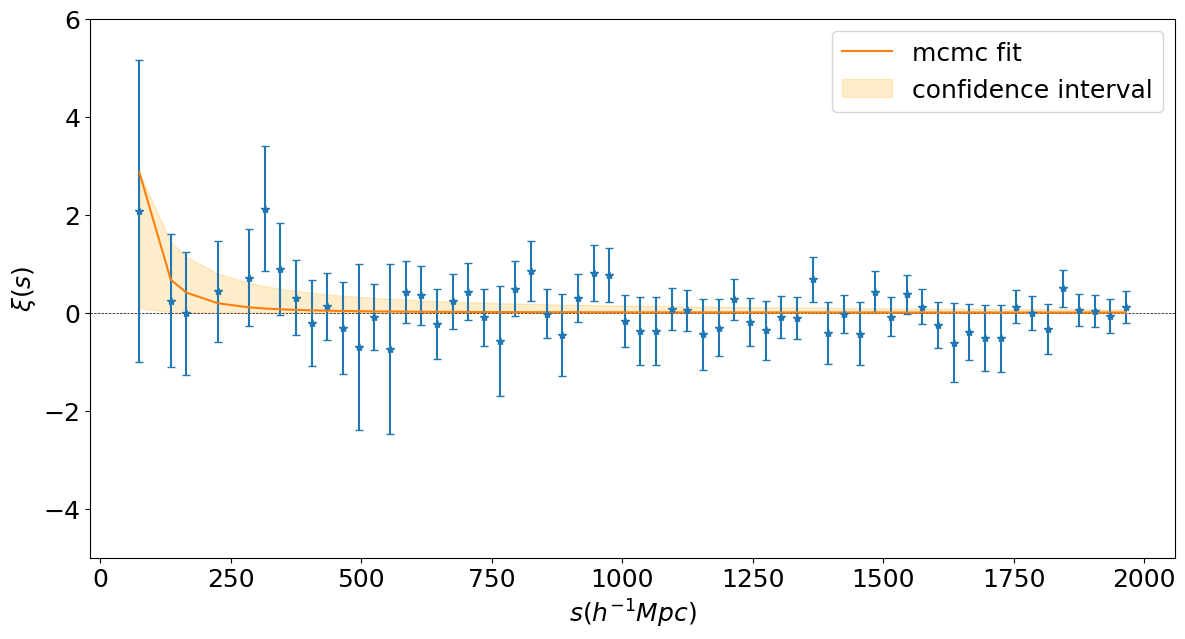

In [13]:
file = open(DP2_DIRECTORY + "Data/" + "latex_table.txt.txt", 'r')
data_here = np.genfromtxt(file) 

s_mid = data_here[:,0]
xi = data_here[:, 8]
xi_err = data_here[:, 10]

loc_here = np.where(~(np.isnan(xi) | np.isnan(xi_err)))

s_mid = s_mid[loc_here]
xi = xi[loc_here]
xi_err = xi_err[loc_here]

mpl.rcParams['font.size'] = 18
fign, axn = plt.subplots(figsize=(14,7))
axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

axn.errorbar(s_mid, xi, xi_err, fmt='*', capsize=3)
axn.set_ylabel(r'$\xi(s)$')
axn.set_xlabel(r'$s (h^{-1}Mpc)$')

fit_clust = pow(s_mid/ 114.66, -2.47)
fit_clust_u = pow(s_mid/ (114.66+69.90), -2.11+0.95)
fit_clust_d = pow(s_mid/ (114.66-74.33), -2.11-1.78)

axn.plot(s_mid, fit_clust, '-', label="mcmc fit")
# axn.plot(s_mid, fit_clust_u, '-', label="mcmc fit")
# axn.plot(s_mid, fit_clust_d, '-', label="mcmc fit")
axn.fill_between(s_mid, fit_clust_d, fit_clust_u, color='orange', alpha=.2, label="confidence interval")
axn.set_ylim(-5,6)
plt.legend()

### Plotting the $s_0$ and $\delta$ vs z graph in the literature and our work

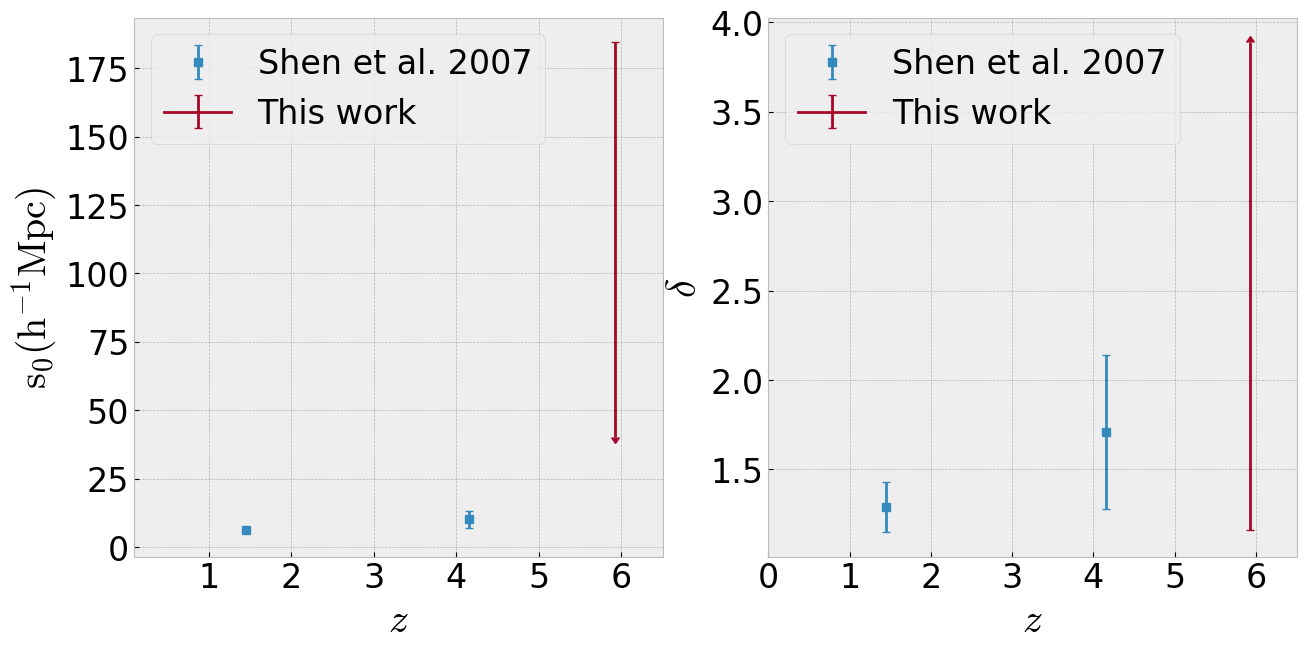

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl


with plt.style.context('bmh'):
    mpl.rcParams['font.size'] = 24
    fig, (ax, ax2) = plt.subplots(1, 2, figsize = (15,7))

    shen_z = [(0.8 + 2.1)/2, (2.9 + 5.4)/2]
    shen_s0 = [6.36, 10.16]
    shen_err = [0.89, 3.08]

    ax.errorbar(shen_z, shen_s0, shen_err, fmt='s', capsize=3, label="Shen et al. 2007")
    ax.errorbar((5.54+6.31)/2, 184.56, [144.23], uplims=True, fmt='-', capsize=3, label="This work")

    ax.set_ylabel(r'$\mathrm{s_0 (h^{-1}Mpc)}$', fontsize='larger')
    ax.set_xlabel(r'$z$', fontsize='larger')
    ax.set_xlim(0.1, 6.5)
    ax.legend()

    shen_z = [(0.8 + 2.1)/2, (2.9 + 5.4)/2]
    shen_del = [1.29, 1.71]
    shen_d_err = [0.14, 0.43]

    ax2.errorbar(shen_z, shen_del, shen_d_err, fmt='s', capsize=3, label="Shen et al. 2007")
    ax2.errorbar((5.54+6.31)/2, 1.16, [2.73], fmt='-', lolims=True, capsize=3, label="This work")
    ax2.set_ylabel(r'$\mathrm{\delta}$', fontsize='larger')
    ax2.set_xlabel(r'$z$', fontsize='larger')
    ax2.set_xlim(0, 6.5)
    ax2.legend()

plt.show()

### Making a clustered sample in PS1 footprint

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


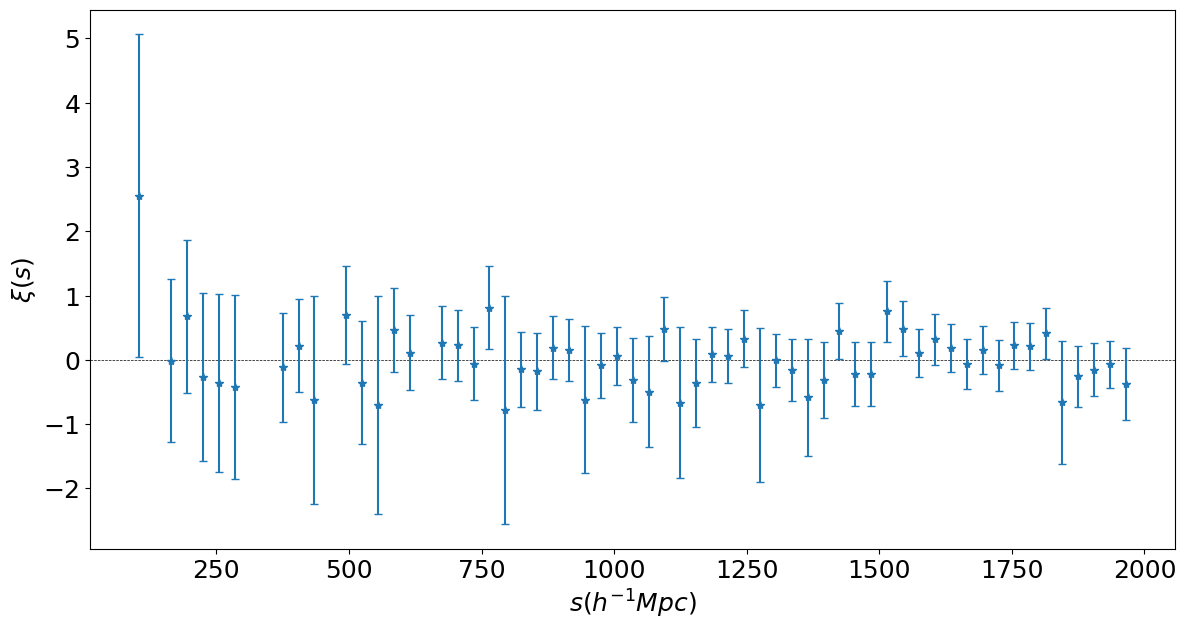

In [2]:
ra, dec, red = make_rand_cat_ps1(1, red_col_schind_23)
find_red_clust_PS1_footprint(ra, dec, red)

In [ ]:
def get_r_from_prob(r0, delta):
    c = np.random.uniform(0, 1, 1)[0]
    A = (1 - delta)/(pow(r0, delta) * (pow(10, 1 - delta) - pow(0.5, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(0.5, 1 - delta)
    return pow(temp1, 1/(1 - delta))

def make_clust_dist_ps1(num, r0, delta):
    r = np.random.uniform(low_r, up_r)
    phi = np.random.uniform(0, 2 * np.pi, 1)[0]
    z = np.random.uniform(-r, r, 1)[0]
    theta = np.arccos(z/r)
    dat_array = np.array(spher_to_cart(r, theta, phi)).reshape(3,1)
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.sum(pow(new_pt, 2)) < low_r | np.sum(pow(new_pt, 2)) > up_r:
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array